In [1]:
import re
from collections import Counter
from itertools import count

import spacy
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from nltk.tokenize import sent_tokenize
from nltk.text import Text

nlp = spacy.load('en_core_web_sm')

Reading the book and getting rid of repetitions:

In [2]:
with open('The Goblet of Fire.txt', encoding='utf-8') as f:
    corpus = f.read()

In [3]:
pattern = r'Page | \d{1,3}\s+Harry Potter and the Goblet of Fire -\s?J.K. Rowling'
corpus = re.sub(pattern, '', corpus)

Tokenizing sentence by sentence:

In [6]:
docs = [nlp(sent) for sent in tqdm(sent_tokenize(corpus))]

Extracting dependencies and the POS info:

In [7]:
def get_deps_n_POS(word, d):
    deps = []
    POS = {}
    for token in d:
        if token.text == word:
            for child in token.children:
                if child.text.isalpha():
                    dep1 = (word, child.text.lower(), child.dep_)
                    deps.append(dep1)
                    POS[child.text.lower()] = child.pos_
                    for grandchild in child.children:
                        if grandchild.text.isalpha():
                            dep2 = (child.text.lower(), grandchild.text.lower(), grandchild.dep_)
                            deps.append(dep2)
                            POS[grandchild.text.lower()] = grandchild.pos_
    return deps, POS

Going through analyses collecting head, dependency, lemma info:

In [8]:
all_deps = []
weights = Counter()
all_POS = {'task': 'NOUN'}
lemmas = []

for d in docs:
    deps, POS = get_deps_n_POS('task', d)
    all_deps.extend(deps)
    weights.update(deps)
    all_POS.update(POS)
    lemmas.extend([token.lemma_ for token in d if token.text.isalpha()])

Creating a graph, edges signal the type of dependency, weight stands for the number of pairs in our corpus: 

In [9]:
G = nx.Graph()
for dep in all_deps:
    w1, w2, dep_v = dep
    G.add_edge(w1, w2, dep=dep_v, weight=weights[dep])

Let's add the attribute pos to the nodes:

In [10]:
for word, pos in all_POS.items():
    G.nodes[word]['pos'] = pos

Manipulations for colouring purposes:

In [11]:
# set of the parts of speech
unique_POS = set(nx.get_node_attributes(G,'pos').values())
# a value for each part of speech
mapping_POS = dict(zip(sorted(unique_POS), count()))
# a list of pos values for the corresponding nodes
colors_POS = [mapping_POS[G.nodes[n]['pos']] for n in G.nodes()]

Some manipulations for the edges:

In [12]:
unique_deps = set(nx.get_edge_attributes(G,'dep').values())
mapping_deps = dict(zip(sorted(unique_deps), count()))
colors_deps = [mapping_deps[G[w1][w2]['dep']] for w1, w2 in G.edges()]

widths = [G[w1][w2]['weight'] / 2 for w1, w2 in G.edges()]

Visualizing the graph, colours correspond to the dependency type:

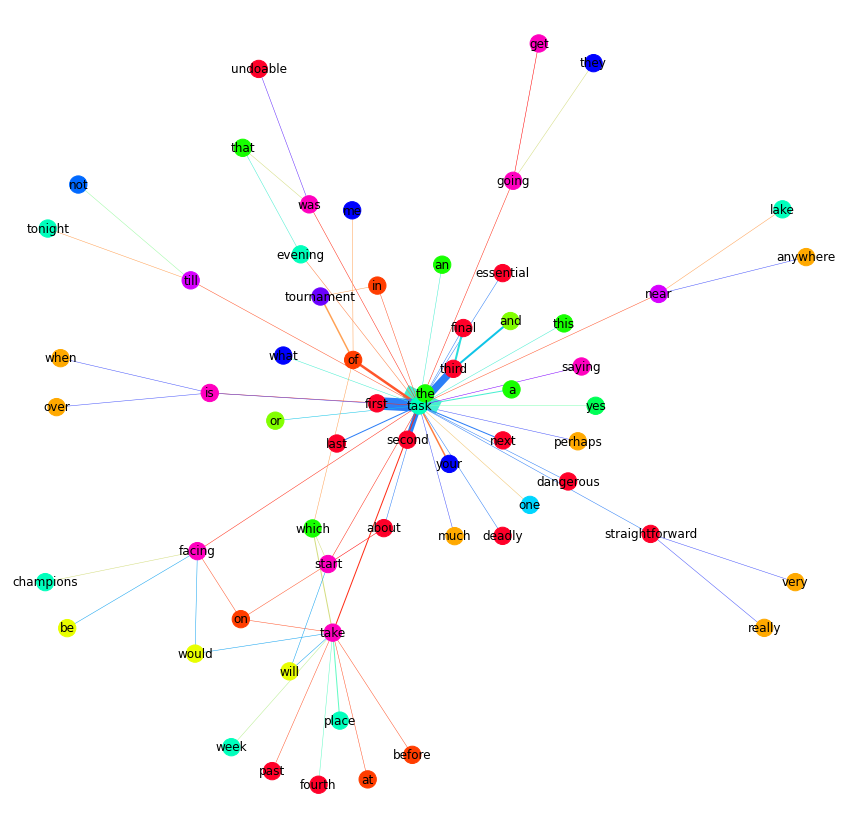

In [13]:
pos = nx.spring_layout(G)
plt.figure(figsize=(15, 15))

nx.draw_networkx_nodes(G, pos, node_color=colors_POS, cmap=plt.cm.gist_rainbow)
nx.draw_networkx_edges(G, pos, width=widths, edge_color=colors_deps, edge_cmap=plt.cm.rainbow)
nx.draw_networkx_labels(G, pos)

plt.axis('off')
plt.show()

Creating a dispersion plot:

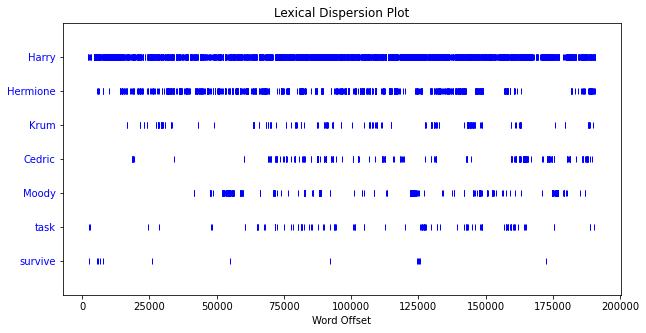

In [27]:
plt.figure(figsize=(10, 5))

text = Text(lemmas)
text.dispersion_plot(['Harry', 'Hermione', 'Krum', 'Cedric', 'Moody', 'task', 'survive'])

The same graph for the word *survive*:

In [21]:
all_deps = []
weights = Counter()
all_POS = {'survive': 'VERB'}
lemmas = []

for d in docs:
    deps, POS = get_deps_n_POS('survive', d)
    all_deps.extend(deps)
    weights.update(deps)
    all_POS.update(POS)
    lemmas.extend([token.lemma_ for token in d if token.text.isalpha()])

In [22]:
G = nx.Graph()
for dep in all_deps:
    w1, w2, dep_v = dep
    G.add_edge(w1, w2, dep=dep_v, weight=weights[dep])

In [23]:
for word, pos in all_POS.items():
    G.nodes[word]['pos'] = pos

In [24]:
unique_POS = set(nx.get_node_attributes(G,'pos').values())
mapping_POS = dict(zip(sorted(unique_POS), count()))
colors_POS = [mapping_POS[G.nodes[n]['pos']] for n in G.nodes()]

In [25]:
unique_deps = set(nx.get_edge_attributes(G,'dep').values())
mapping_deps = dict(zip(sorted(unique_deps), count()))
colors_deps = [mapping_deps[G[w1][w2]['dep']] for w1, w2 in G.edges()]

widths = [G[w1][w2]['weight'] / 2 for w1, w2 in G.edges()]

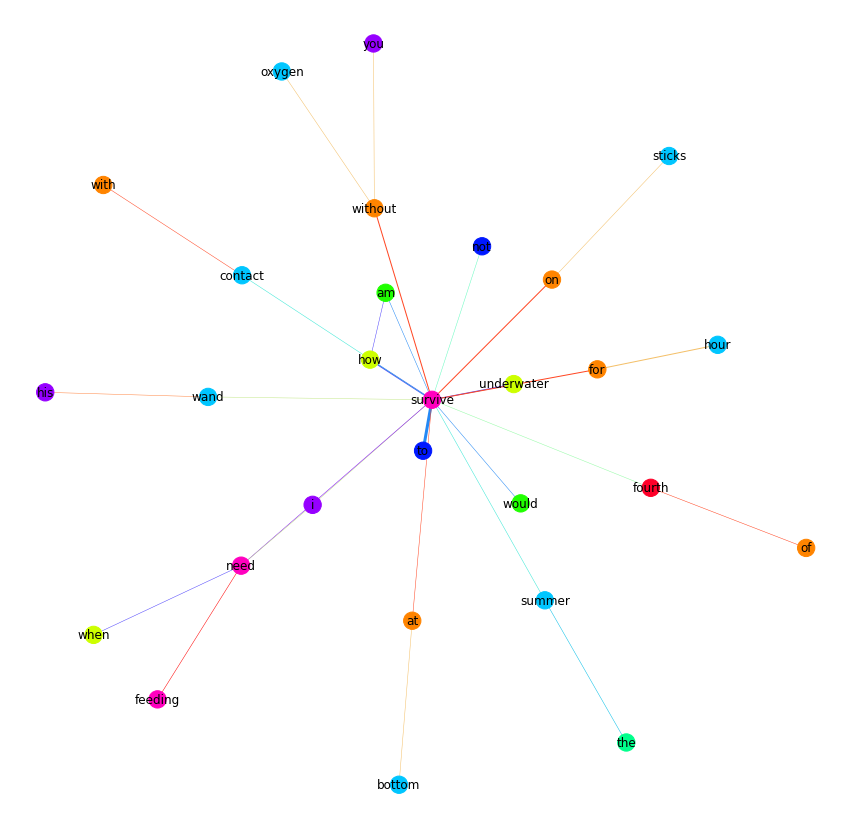

In [26]:
pos = nx.spring_layout(G)
plt.figure(figsize=(15, 15))

nx.draw_networkx_nodes(G, pos, node_color=colors_POS, cmap=plt.cm.gist_rainbow)
nx.draw_networkx_edges(G, pos, width=widths, edge_color=colors_deps, edge_cmap=plt.cm.rainbow)
nx.draw_networkx_labels(G, pos)

plt.axis('off')
plt.show()